In [99]:
import pandas as pd
import seaborn as sns

df = pd.read_csv('diabetes.csv')

df.sample(5)

pregnant-times  glucose-concentr  blood-pressure  skin-thickness  \
83                0               101              65              28   
113               4                76              62               0   
268               0               102              52               0   
566               1                99              72              30   
523               9               130              70               0   

     insulin  mass-index  pedigree-func  age            class  
83         0        24.6          0.237   22  tested_negative  
113        0        34.0          0.391   25  tested_negative  
268        0        25.1          0.078   21  tested_negative  
566       18        38.6          0.412   21  tested_negative  
523        0        34.2          0.652   45  tested_positive

In [100]:
#How many tested_positive and tested_negative are in the dataset
df['class'].value_counts()

class
tested_negative    500
tested_positive    268
Name: count, dtype: int64

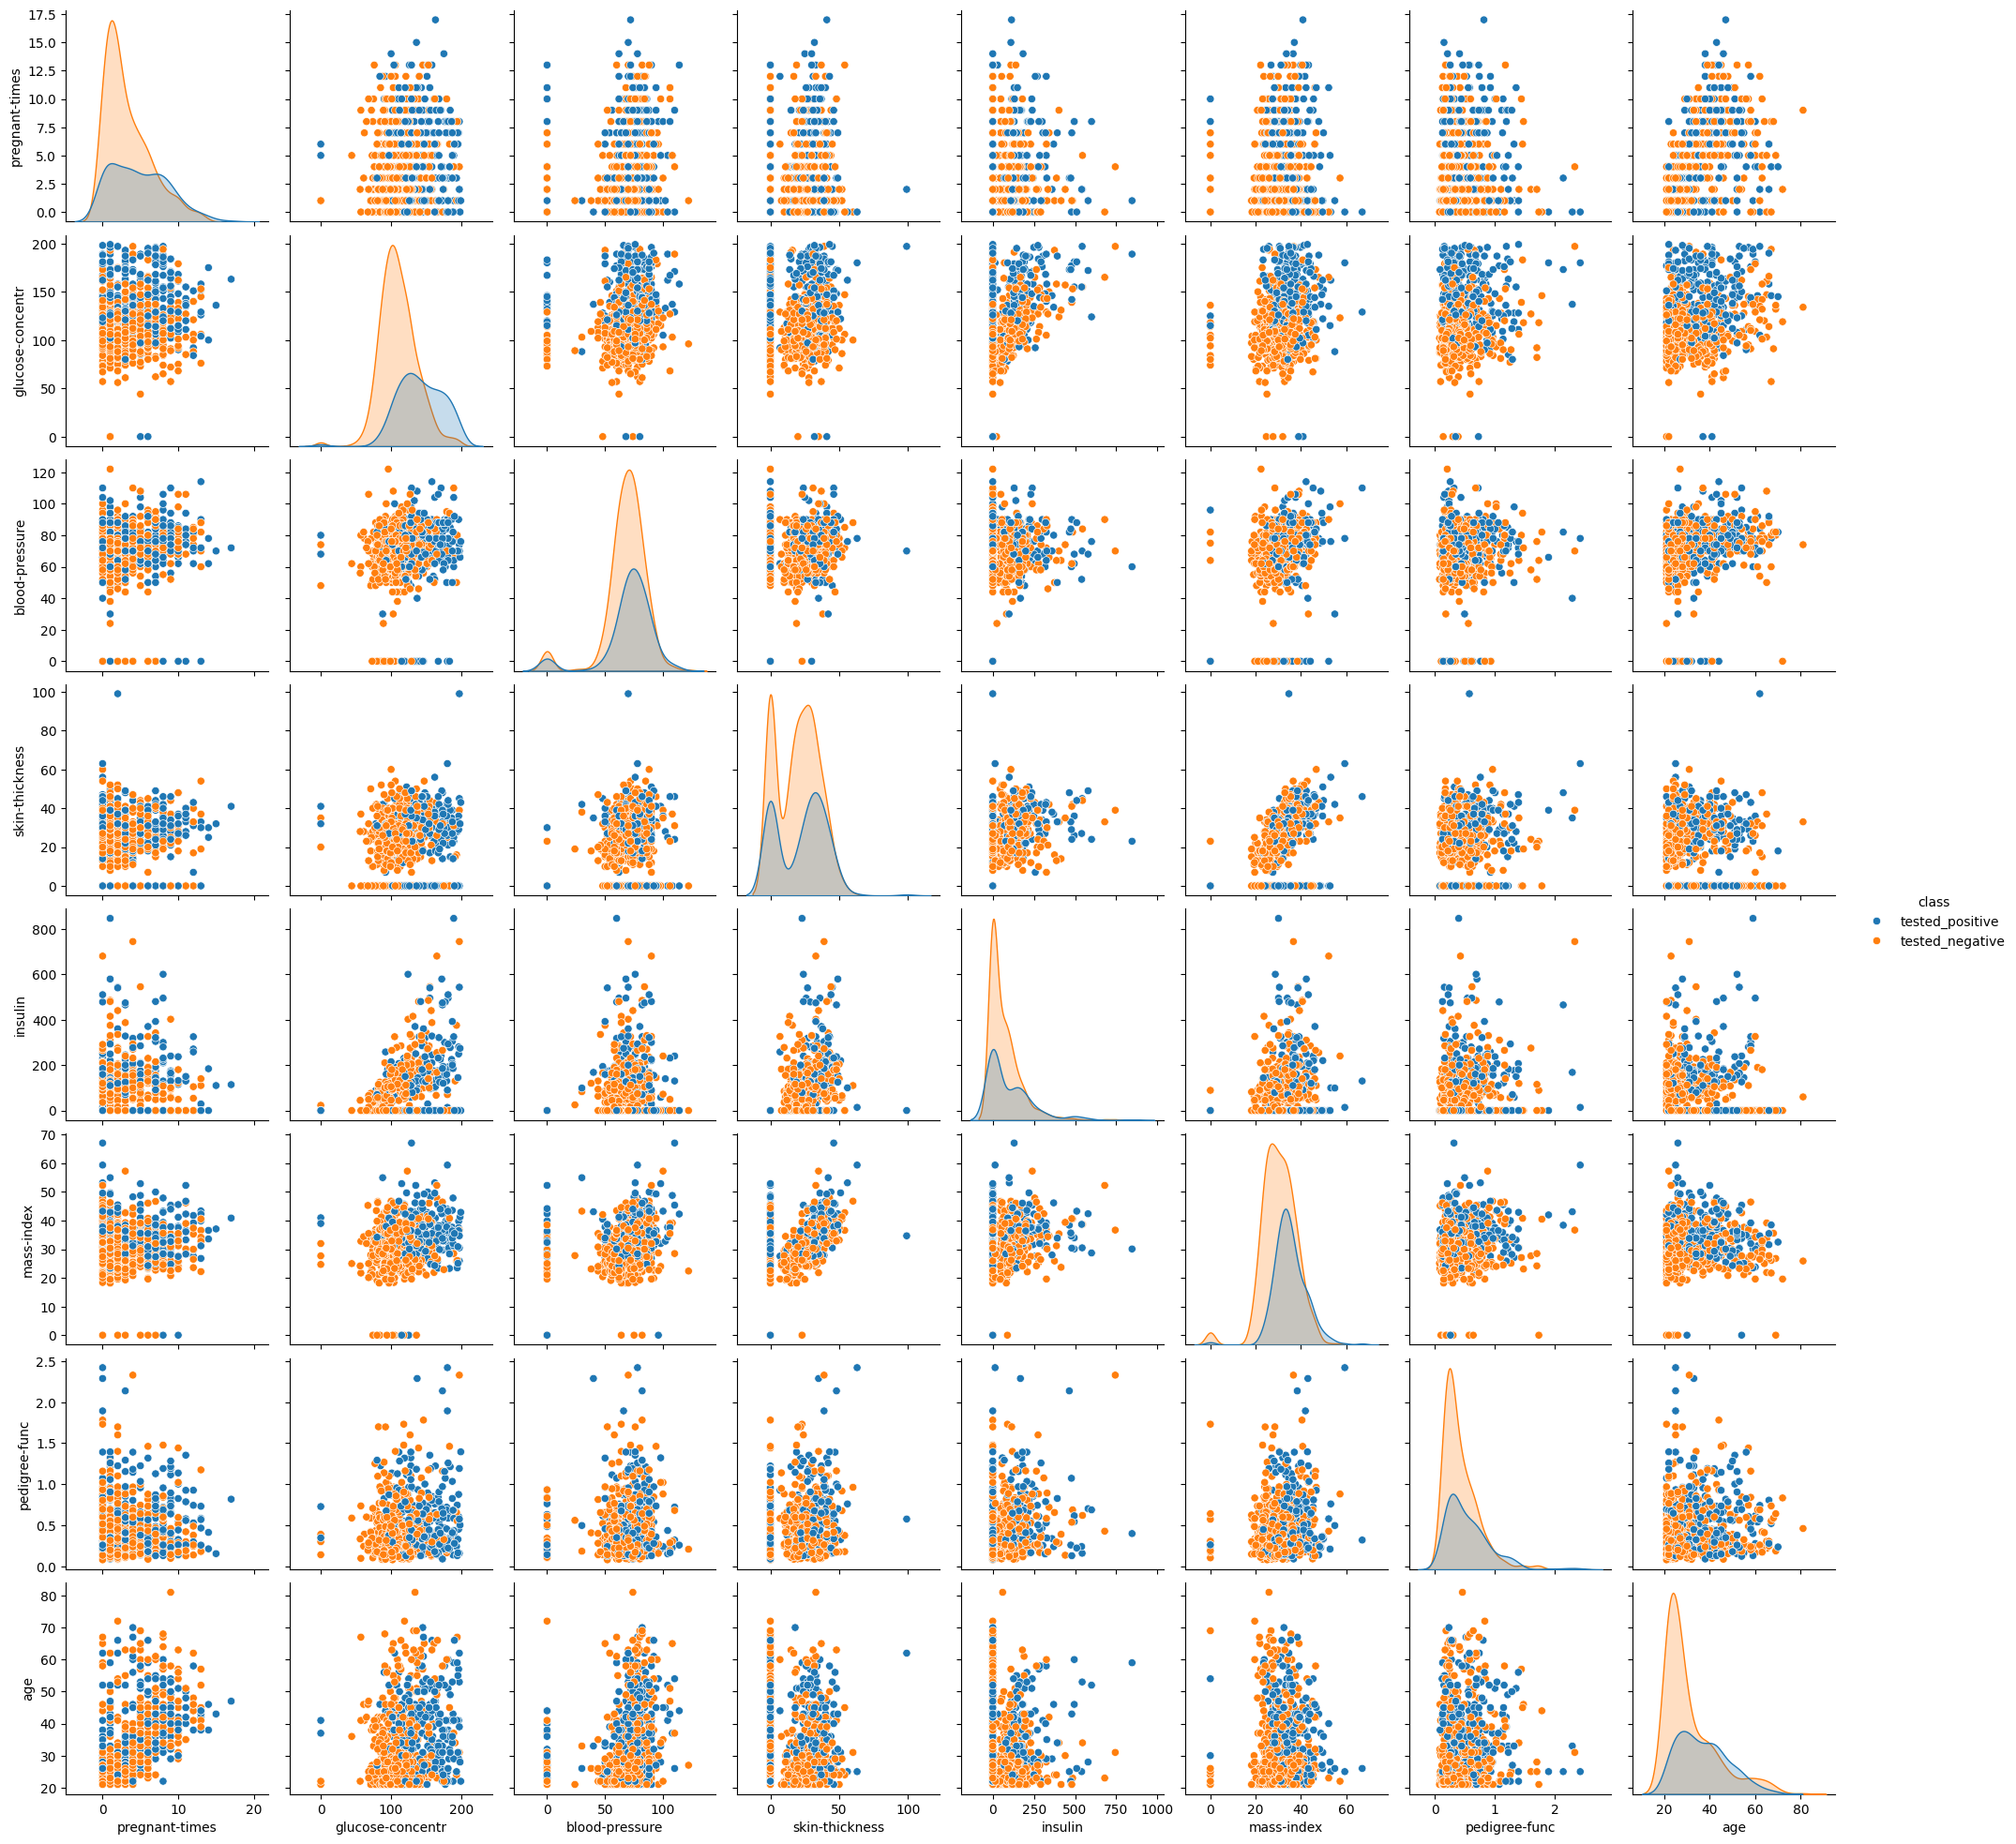

In [101]:
sns.pairplot(df, hue='class')

In [102]:
# data cleaning so we will fix rows with 0 values also rows with some strings like - or nan and also minus values 
# first of all lets identify count of such rows

#How many strings values are in the dataset
df.applymap(lambda x: isinstance(x, str)).sum()

#No strings values found

/tmp/ipykernel_4757/2626894840.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.applymap(lambda x: isinstance(x, str)).sum()


pregnant-times        0
glucose-concentr      0
blood-pressure        0
skin-thickness        0
insulin               0
mass-index            0
pedigree-func         0
age                   0
class               768
dtype: int64

In [103]:
#How many values are less than or equal to 0 in first 8 columns
(df.iloc[:, :8] <= 0).sum()

#We have many 0 values which should be fixed. We will replace them using KNN approach

pregnant-times      111
glucose-concentr      5
blood-pressure       35
skin-thickness      227
insulin             374
mass-index           11
pedigree-func         0
age                   0
dtype: int64

In [104]:
#--- Start data preparation for imputation ---
# We will replace class values with 0 and 1
# We will replace 0 values with NaN for selected columns
import numpy as np

cols_to_impute = [
    'glucose-concentr',
    'blood-pressure',
    'skin-thickness',
    'insulin',
    'mass-index'
]
df_impute = df.copy()
class_mapping = {
    'tested_positive': 1,
    'tested_negative': 0
}
df_impute['class'] = df_impute['class'].map(class_mapping)

df_impute[cols_to_impute] = df_impute[cols_to_impute].replace(0, np.nan)
print(df_impute.isna().sum())

pregnant-times        0
glucose-concentr      5
blood-pressure       35
skin-thickness      227
insulin             374
mass-index           11
pedigree-func         0
age                   0
class                 0
dtype: int64


In [105]:
#KNN Imputation
from sklearn.impute import KNNImputer

df_features = df_impute.drop(columns=['class'])
df_target = df_impute['class']

imputer = KNNImputer(n_neighbors=5)

df_imputed_array = imputer.fit_transform(df_features)
df_cleaned_features = pd.DataFrame(df_imputed_array, columns=df_features.columns)
df_cleaned = pd.concat([df_cleaned_features, df_target], axis=1)

print("\n--- Verification (Min values in imputed columns) ---")
print(df_cleaned[cols_to_impute].min())

print("\n--- Sample of Cleaned Data ---")
print(df_cleaned.sample(5))


--- Verification (Min values in imputed columns) ---
glucose-concentr    44.0
blood-pressure      24.0
skin-thickness       7.0
insulin             14.0
mass-index          18.2
dtype: float64

--- Sample of Cleaned Data ---
     pregnant-times  glucose-concentr  blood-pressure  skin-thickness  \
513             2.0              91.0            62.0            20.6   
343             5.0             122.0            86.0            28.6   
449             0.0             120.0            74.0            18.0   
72             13.0             126.0            90.0            34.4   
358            12.0              88.0            74.0            40.0   

     insulin  mass-index  pedigree-func   age  class  
513     66.4        27.3          0.525  22.0      0  
343    166.2        34.7          0.290  33.0      0  
449     63.0        30.5          0.285  26.0      0  
72     125.6        43.4          0.583  42.0      1  
358     54.0        35.3          0.378  48.0      0  


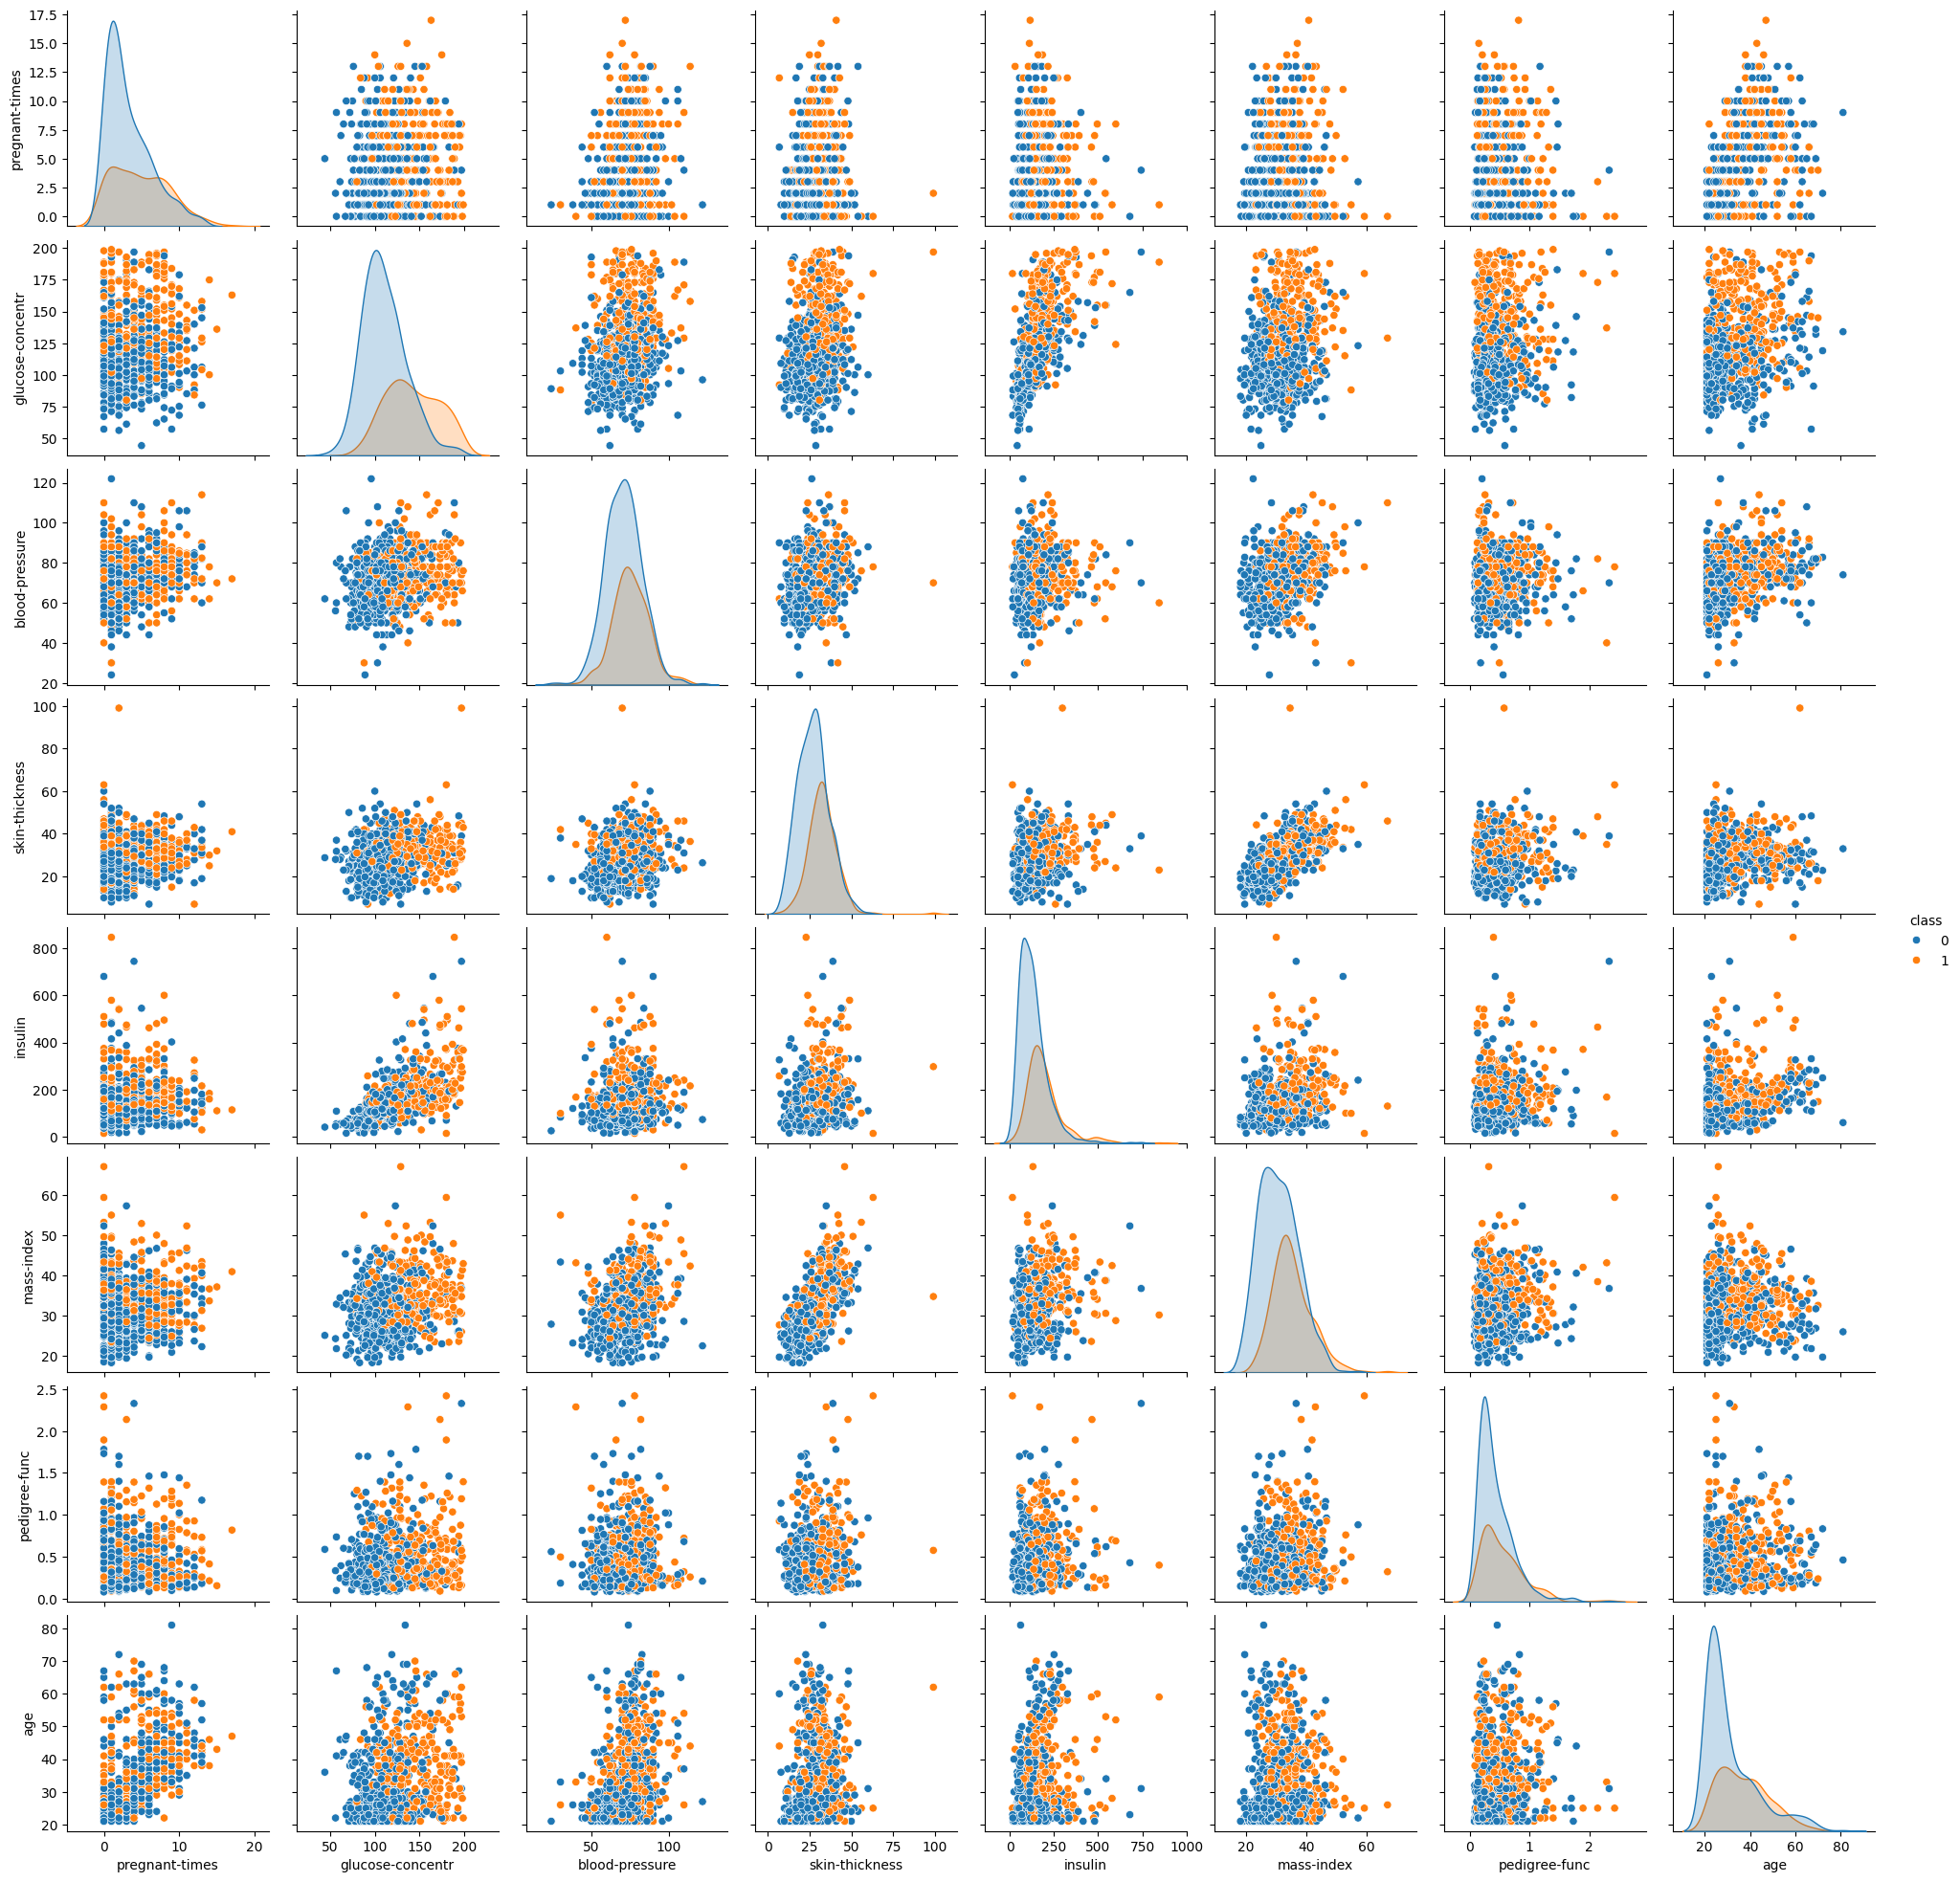

In [106]:
#lets see sns pairplot for cleaned data
sns.pairplot(df_cleaned, hue='class')

#Now we can see that there is no these weird 0 values on the plots

In [107]:
#Now we have cleaned data and now we can proceed with normalization for which we will use standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled_features_array = scaler.fit_transform(df_cleaned.drop(columns=['class']))
df_scaled_features = pd.DataFrame(df_scaled_features_array, columns=df_cleaned.columns[:-1])
df_final = pd.concat([df_scaled_features, df_cleaned['class']], axis=1)
print("\n--- Sample of Final Scaled Data ---")
print(df_final.sample(5))



--- Sample of Final Scaled Data ---
     pregnant-times  glucose-concentr  blood-pressure  skin-thickness  \
488        0.046014         -0.741491       -0.031424       -1.285402   
338        1.530847          0.997544        0.460424        0.519874   
162       -1.141852         -0.249311        0.624373        0.519874   
253       -1.141852         -1.168046       -0.359322        0.307489   
199        0.046014          0.866296       -1.015118       -0.223475   

      insulin  mass-index  pedigree-func       age  class  
488 -1.008700   -0.991795      -0.537208 -0.445935      0  
338  0.182654    0.257954       1.271844 -0.020496      1  
162  1.343461    1.711149      -0.920763 -0.531023      0  
253 -0.444589    0.490465      -0.706334 -0.701198      0  
199  1.679484   -0.221601      -0.972105 -0.360847      1  


In [108]:
#cleaning and normalization completed now we proceed with dividing data into train and test sets
from sklearn.model_selection import train_test_split
X = df_final.drop(columns=['class'])
y = df_final['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTrain set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")



Train set size: 614 samples
Test set size: 154 samples


<Axes: title={'center': 'Decision Tree Confusion Matrix\nAccuracy: 67.53%'}>

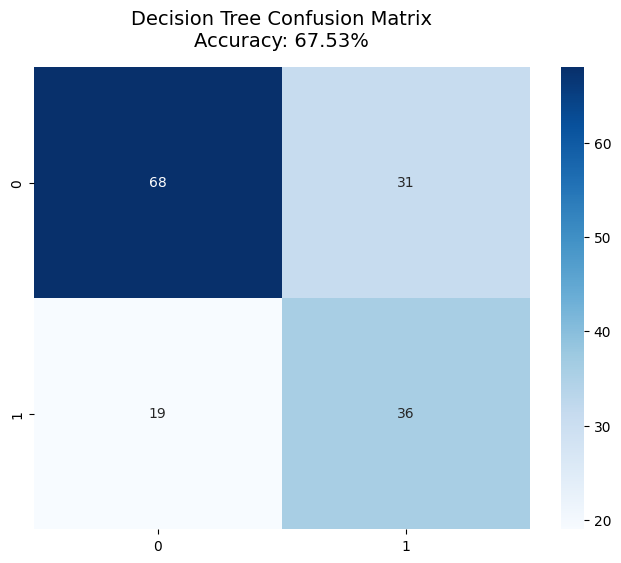

In [109]:
#Now check all possible calssifiers on this data

#DECISION TREE CLASSIFIER
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
score_dtc = dtc.score(X_test, y_test)

dtc_predictions = dtc.predict(X_test)
dtc_cm = confusion_matrix(y_test, dtc_predictions)

plt.figure(figsize=(8, 6))
plt.title(f'Decision Tree Confusion Matrix\nAccuracy: {score_dtc*100:.2f}%', fontsize=14, pad=15)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

sns.heatmap(dtc_cm, annot=True, fmt='d', cmap='Blues')


<Axes: title={'center': 'KNN Confusion Matrix\nAccuracy: 75.97%'}>

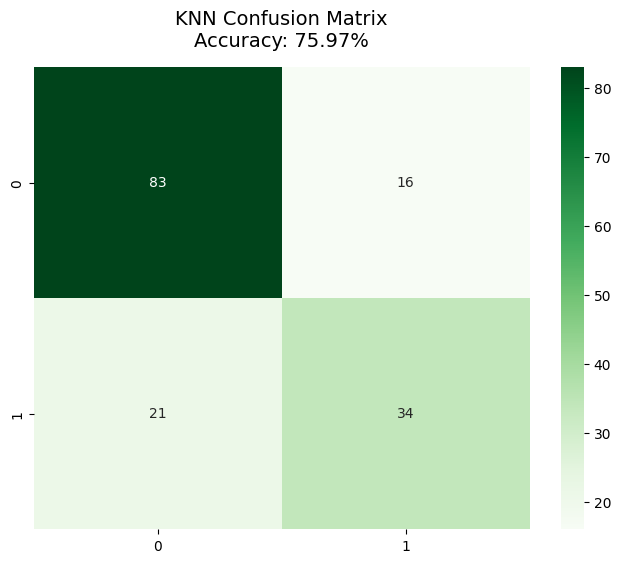

In [110]:
#KNN CLASSIFIER
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

#I tried with different k values and 26 gave best results
knn = KNeighborsClassifier(n_neighbors=26)
knn.fit(X_train, y_train)
score_knn = knn.score(X_test, y_test)
knn_predictions = knn.predict(X_test)
knn_cm = confusion_matrix(y_test, knn_predictions)

plt.figure(figsize=(8, 6))
plt.title(f'KNN Confusion Matrix\nAccuracy: {score_knn*100:.2f}%', fontsize=14, pad=15)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Greens')

<Axes: title={'center': 'Naive Bayes Confusion Matrix\nAccuracy: 74.03%'}>

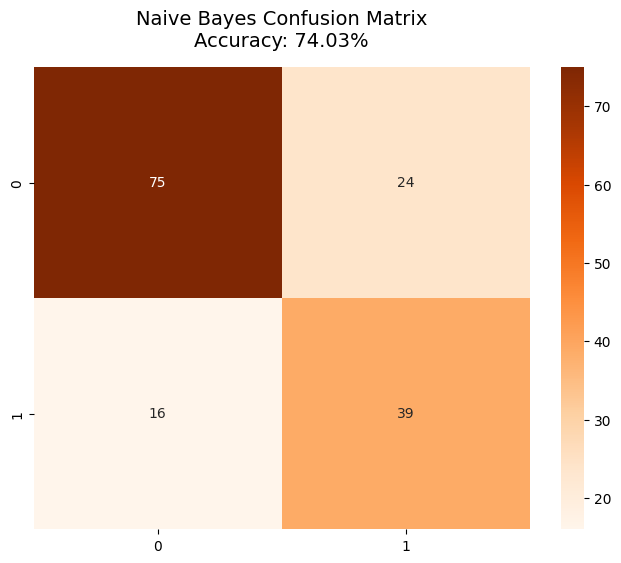

In [111]:
# NAIVE BAYES CLASSIFIER
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
gnb = GaussianNB()
gnb.fit(X_train, y_train)
score_gnb = gnb.score(X_test, y_test)
gnb_predictions = gnb.predict(X_test)
gnb_cm = confusion_matrix(y_test, gnb_predictions)

plt.figure(figsize=(8, 6))
plt.title(f'Naive Bayes Confusion Matrix\nAccuracy: {score_gnb*100:.2f}%', fontsize=14, pad=15)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

sns.heatmap(gnb_cm, annot=True, fmt='d', cmap='Oranges')

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01, 'solver': 'sgd'}
Test Accuracy with best parameters: 77.92%


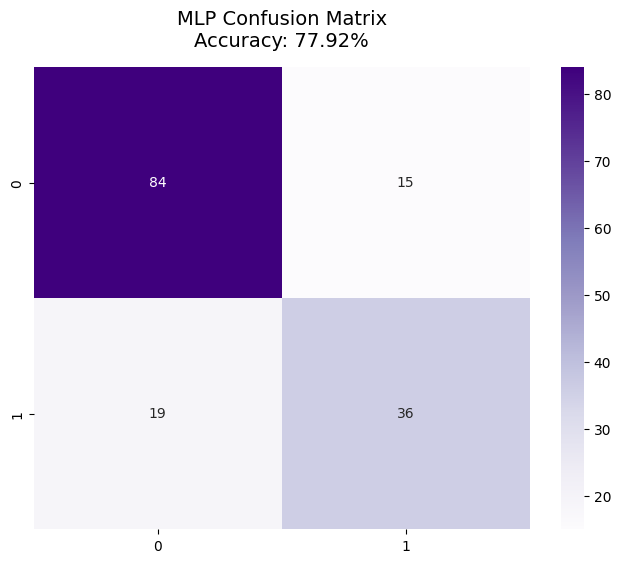

In [112]:
#MLP CLASSIFIER with different architectures
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

parameter_space = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50, 25)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01]
}

mlp_gs = MLPClassifier(max_iter=2500, random_state=42)
clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=3, scoring='accuracy')

clf.fit(X_train, y_train)
best_mlp = clf.best_estimator_
score_mlp = best_mlp.score(X_test, y_test)
mlp_predictions = best_mlp.predict(X_test)
mlp_cm = confusion_matrix(y_test, mlp_predictions)
print('Best parameters found:\n', clf.best_params_)
best_score = clf.score(X_test, y_test)
print(f'Test Accuracy with best parameters: {best_score*100:.2f}%')
plt.figure(figsize=(8, 6))
plt.title(f'MLP Confusion Matrix\nAccuracy: {score_mlp*100:.2f}%', fontsize=14, pad=15)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Purples')

plt.show()

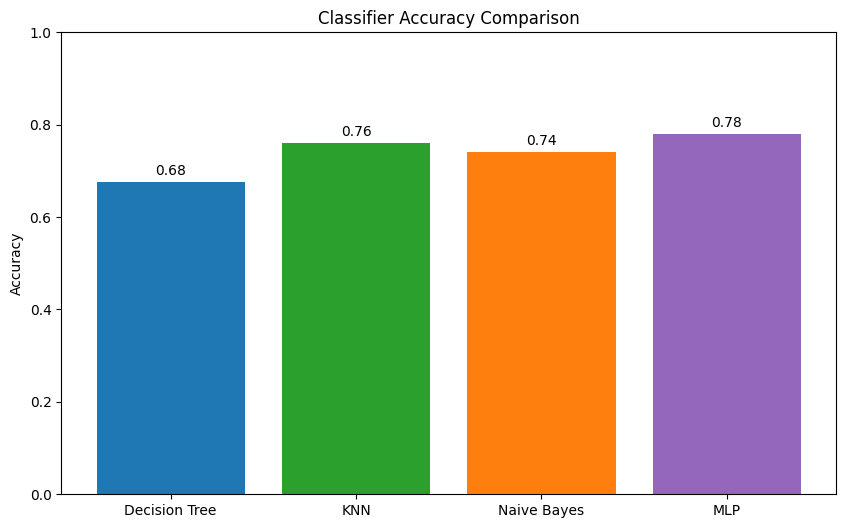

In [115]:
# create sum up of scores of each classifier in a chart

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


classifiers = ['Decision Tree', 'KNN', 'Naive Bayes', 'MLP']
scores = [score_dtc, score_knn, score_gnb, score_mlp]

plt.figure(figsize=(10, 6))
bars = plt.bar(classifiers, scores, color=['#1f77b4', '#2ca02c', '#ff7f0e', '#9467bd'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Classifier Accuracy Comparison')

for bar in bars:
    yval = bar.get_height() 
    plt.text(
        bar.get_x() + bar.get_width()/2,
        yval + 0.01,
        f'{yval:.2f}', 
        ha='center', 
        va='bottom', 
        fontsize=10
    )

plt.show()